In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import all the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import warnings
import matplotlib.patches as patches
from pathlib import Path
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from torch.utils.data import TensorDataset, DataLoader
import os
output_dir = "./outputs/NN_Files_3D_scaled_opt_2"

# Functions

### Ready Functions

In [3]:
#This function evaluates the specific angular coefficients at given energy value

def Y(energy, f_mode):
    """Evaluate angular coefficient vector Y for given energy and mode.

    Parameters:
        energy (torch.Tensor): input energy (expected in PeV-range; scalar or 1-element tensor).
        f_mode (str): mode string selecting parameterization (e.g. 'mg0','mg2','eg0',...).

    Returns:
        torch.Tensor: shape (4, 1) tensor with evaluated coefficients used by interpolation routines.
    """
    Y = torch.zeros((4, 1))

    #Convert Energy to PeV
    xe = .5 + 20 * (torch.log(energy) - log_01) / (log_10 - log_01)
    xe2 = xe * xe

    #Evaluate Y for given energy and mode
    for i in range(4):
        if f_mode == "mg0":
            Y[i] = torch.exp(PXmg_p[i, 0, 0]) + torch.exp(PXmg_p[i ,0, 1] * torch.pow(xe, PXmg_p[i, 0, 2]))

        elif f_mode == "mg2":
            Y[i] = PXmg_p[i, 2, 0] + PXmg_p[i, 2, 1] * xe + PXmg_p[i, 2, 2] * xe2

        elif f_mode == "eg0":
            Y[i] = PXeg_p[i, 0, 0] * torch.exp(PXeg_p[i, 0, 1] * torch.pow(xe, PXeg_p[i, 0, 2]))

        elif f_mode == "eg1":
            Y[i] = PXeg_p[i, 1, 0] + PXeg_p[i, 1, 1] * xe + PXeg_p[i, 1, 2] * xe2

        elif f_mode == "eg2":
            Y[i] = PXeg_p[i, 2, 0] + PXeg_p[i, 2, 1] * xe + PXeg_p[i, 2, 2] * xe2

        elif f_mode == "mp0":
            Y[i] = torch.exp(PXmp_p[i, 0, 0]) + torch.exp(PXmp_p[i, 0, 1] * torch.pow(xe, PXmp_p[i, 0, 2]))

        elif f_mode == "mp2":
            Y[i] = PXmp_p[i, 2, 0] + PXmp_p[i, 2, 1] * xe + PXmp_p[i, 2, 2] * xe2

        elif f_mode == "ep0":
            Y[i] = torch.exp(PXep_p[i, 0, 0]) + torch.exp(PXep_p[i, 0, 1] * torch.pow(xe, PXep_p[i, 0, 2]))

        elif f_mode == "ep1":
            Y[i] = PXep_p[i, 1, 0] + PXep_p[i, 1, 1] * xe + PXep_p[i, 1, 2] * xe2

        elif f_mode == "ep2":
            Y[i] = PXep_p[i, 2, 0] + PXep_p[i, 2, 1] * xe + PXep_p[i, 2, 2] * xe2

        else:
            warnings.warn("The Mode is not defined")
            return

    return Y

In [4]:
#Interpolated parameter computation
#thisp0 = normalization constant
#thisp1 = slope parameter
#thisp2 = shape parameter

def thisp(energy, theta, f_mode):
    """Compute interpolated parameter value for a given energy, incident angle and parameter mode.

    The function evaluates the angular coefficients via `Y`, solves a small linear system to get
    polynomial coefficients `B`, then evaluates a polynomial in `x(theta)` to return a single parameter.

    Parameters:
        energy (torch.Tensor): shower energy.
        theta (torch.Tensor): shower incident angle.
        f_mode (str): mode string (e.g. 'mg0', 'eg1', 'mp2').

    Returns:
        torch.Tensor: interpolated scalar parameter value used in the flux parametrization.
    """
    #Find Y values
    Y_val = Y(energy, f_mode)

    #Solve for B
    B = torch.linalg.solve(A, Y_val)

    #Define x from theta
    x = .5 + 4 * theta / theta_max

    res = 0

    for i in range(4):
        res += B[i] * x ** i

    return res

In [5]:
def ReadShowers(path_g, path_p):
    """Read fitted parameter blocks for gamma and proton showers from text files.

    Expects both files to contain 4 parameter blocks for electrons and muons (each block of 3 rows
    and 3 columns). Performs a simple validation (warns and returns None if a block contains zeros)
    and returns the parameter tensors as torch.Tensor objects.

    Parameters:
        path_g (str): path to gamma-fit text file.
        path_p (str): path to proton-fit text file.

    Returns:
        tuple: (PXmg_p, PXeg_p, PXmp_p, PXep_p) each a torch.Tensor of shape (4,3,3), or None on error.
    """
    #GAMMA SHOWERS
    #Reading the Electron Parameters in the Showers
    PXeg1_p = np.loadtxt(path_g, max_rows = 3)

    for i in range(3):
        if PXeg1_p[i, 0]*PXeg1_p[i, 1]*PXeg1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg2_p = np.loadtxt(path_g, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXeg2_p[i, 0]*PXeg2_p[i, 1]*PXeg2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg3_p = np.loadtxt(path_g, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXeg3_p[i, 0]*PXeg3_p[i, 1]*PXeg3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg4_p = np.loadtxt(path_g, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXeg4_p[i, 0]*PXeg4_p[i, 1]*PXeg4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmg1_p = np.loadtxt(path_g, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmg1_p[i, 0]*PXmg1_p[i, 1]*PXmg1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return
            
    PXmg2_p = np.loadtxt(path_g, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmg2_p[i, 0]*PXmg2_p[i, 1]*PXmg2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg3_p = np.loadtxt(path_g, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmg3_p[i, 0]*PXmg3_p[i, 1]*PXmg3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg4_p = np.loadtxt(path_g, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmg4_p[i, 0]*PXmg4_p[i, 1]*PXmg4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    #PROTON SHOWERS
    #Reading the Electron Parameters in the Showers
    PXep1_p = np.loadtxt(path_p, max_rows = 3)

    for i in range(3):
        if PXep1_p[i, 0]*PXep1_p[i, 1]*PXep1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep2_p = np.loadtxt(path_p, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXep2_p[i, 0]*PXep2_p[i, 1]*PXep2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep3_p = np.loadtxt(path_p, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXep3_p[i, 0]*PXep3_p[i, 1]*PXep3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep4_p = np.loadtxt(path_p, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXep4_p[i, 0]*PXep4_p[i, 1]*PXep4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmp1_p = np.loadtxt(path_p, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmp1_p[i, 0]*PXmp1_p[i, 1]*PXmp1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp2_p = np.loadtxt(path_p, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmp2_p[i, 0]*PXmp2_p[i, 1]*PXmp2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp3_p = np.loadtxt(path_p, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmp3_p[i, 0]*PXmp3_p[i, 1]*PXmp3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp4_p = np.loadtxt(path_p, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmp4_p[i, 0]*PXmp4_p[i, 1]*PXmp4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg_p = torch.tensor([PXmg1_p, PXmg2_p, PXmg3_p, PXmg4_p])
    PXeg_p = torch.tensor([PXeg1_p, PXeg2_p, PXeg3_p, PXeg4_p])
    PXmp_p = torch.tensor([PXmp1_p, PXmp2_p, PXmp3_p, PXmp4_p])
    PXep_p = torch.tensor([PXep1_p, PXep2_p, PXep3_p, PXep4_p])

    return PXmg_p, PXeg_p, PXmp_p, PXep_p

In [6]:
#This function defines the initial layouts of the detectors, N_det = 90
#At this point of the project, we just define a square grid

def Layouts(n_detectors=100, n_rings=6):
    """Create a detector layout with detectors distributed across concentric rings.

    Parameters:
        n_detectors (int): total number of detectors.
        n_rings (int): number of concentric rings.

    Returns:
        tuple: (x, y) numpy arrays of detector positions in meters.
    """
    # Distribute detectors across rings proportional to circumference (i.e. radius)
    # R = [50, 200, 350, 550, 750, 1000]
    # R = [0.5, 2.0, 3.5, 5.5, 7.5, 10]
    # R = [5, 20, 35, 55, 75, 100]
    R = np.linspace(5, 100, n_rings)
    
    weights = R / R.sum()
    N = np.round(weights * n_detectors).astype(int)

    # Fix rounding so total matches exactly
    diff = n_detectors - N.sum()
    # Add/remove from the outermost ring
    N[-1] += diff

    radii = np.repeat(R, N)
    angles = np.concatenate([np.linspace(0, 2 * np.pi, n, endpoint=False) for n in N])

    return radii * np.cos(angles), radii * np.sin(angles)

### Functions to redo

#### Instantiate generator

In [7]:
torch.cuda.is_available()

True

In [8]:
from diffusion_model.tambo_3D_diffusion_generator import PlaneDiffusionEvaluator

# Initialize with custom parameters
generator = PlaneDiffusionEvaluator(
    data_dir =  "/n/netscratch/arguelles_delgado_lab/Everyone/hhanif/tambo_simulation_nov_25/pre_processed_3rd_step/",
    checkpoint_path =  "/n/netscratch/arguelles_delgado_lab/Everyone/hhanif/tambo_simulation_nov_25/checkpoints/tam_unet/epoch_epoch=1229-val_loss_val_loss=0.0333.ckpt",
    ddim_steps =  10,
    eta =  0.0,
    guidance_w =  1.8,
    imports_path = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/hhanif/tambo_optimization/unet"
    )

generator.load_model()


Initialized PlaneDiffusionEvaluator
Device: cuda:0
Model parameters: 12,408,387
Loaded checkpoint: /n/netscratch/arguelles_delgado_lab/Everyone/hhanif/tambo_simulation_nov_25/checkpoints/tam_unet/epoch_epoch=1229-val_loss_val_loss=0.0333.ckpt
DDIM sampler built (ddim_steps=10, eta=0.0, w=1.8)
Model loading time: 0.89s


In [9]:

# add scaling
from diffusion_model.tambo_3D_fnn_scaler import PlaneFNNGenerator
import torch

# Initialize
scaler = PlaneFNNGenerator(
    data_dir="/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/zdimitrov/tambo_simulations/pre_processed_3rd_step_min_50/",
    checkpoint_path="/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/zdimitrov/tambo_simulations/checkpoints/tam_fnn/last.ckpt",
    output_dir="fnn_outputs",
    imports_path="/n/home05/zdimitrov/tambo/TambOpt/ml/scaling_NN/FNN/"
)
scaler.load_model()


Initialized PlaneFNNGenerator
Device: cuda:0
Output directory: fnn_outputs
Loaded standardization stats from: /n/holylfs05/LABS/arguelles_delgado_lab/Everyone/zdimitrov/tambo_simulations/pre_processed_3rd_step_min_50/global_bbox_stats.pt
  Mean: 90.71444702148438
  Std: 140.77218627929688
Model parameters: 3,751,008
Loaded checkpoint: /n/holylfs05/LABS/arguelles_delgado_lab/Everyone/zdimitrov/tambo_simulations/checkpoints/tam_fnn/last.ckpt
Using EMA weights for inference
Model parameters: 3,751,008
Model loading time: 0.20s


In [10]:
torch.rand(2)

tensor([0.7809, 0.1223])

In [11]:
[np.random.uniform(0, 1)]

[0.9600173033359185]

In [12]:
def GenerateShowers(x, y, log=False, number_of_showers=1):
    """Randomly generate the showers, getting the energy, angle, and position of the shower core

    Parameters:
        x (torch.Tensor): detector x positions.
        y (torch.Tensor): detector y positions.

    Returns:
        tuple: (N, T, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a)
            N (torch.Tensor): per-detector counts (Ne + Nm).
            T (torch.Tensor): per-detector time-of-arrival.
            X0, Y0 (torch.Tensor): shower core position.
            energy, sin_z, cos_z, sin_a, cos_a (torch.Tensor): shower truth parameters.
    """

    #Define the energy and angles
    p_energy = torch.rand(number_of_showers) * 1.0  # Energy in PeV, uniformly distributed between 0 and 1
    sin_zenith = torch.rand(number_of_showers) * 2 - 1  # Uniformly distributed between -1 and 1
    sin_azimuth = torch.rand(number_of_showers) * 2 - 1  # Uniformly distributed between -1 and 1
    # split theta and phi in cos and sin components if needed
    sin_z = sin_zenith
    cos_z = torch.sqrt(1 - sin_zenith**2)
    sin_a = sin_azimuth
    cos_a = torch.sqrt(1 - sin_azimuth**2)
    
    # TODO hardcoded for now
    class_id = torch.ones(number_of_showers) # for gamma showers
    
    # input parameters 
    generator.test_conditions = torch.stack([p_energy, class_id,  sin_z, cos_z, sin_a, cos_a], dim=1)
    scaler.test_conditions = torch.stack([p_energy, class_id, sin_z, cos_z, sin_a, cos_a], dim=1)
    
    # generate shower
    outputs_arr = generator.generate_samples(num_conditions=number_of_showers)
    output_images = outputs_arr['images'] # number_of_showers x planes x channels x H x W
    shower_rgb = output_images[:, 20, :, :, :] # use plane 20 for now
    shower_rgb = shower_rgb.permute(0, 2, 3,1)
    
    # generate bboxes
    outputs_arr_bboxes = scaler.generate_samples(num_conditions=number_of_showers)
    bboxes = outputs_arr_bboxes['bboxes'][:,20,:]  # use plane 20 for now
    
    if log:
        plt.imshow(shower_rgb[0])
        print('BBox:', bboxes )
    
    # compute x0, y0 after generating the shower from the mean of the distribution over x, y
    location_means = torch.prod(shower_rgb[:, :, :, :2], dim=3)
    # Create position grids
    i_indices = torch.arange(32, dtype=torch.float32)
    j_indices = torch.arange(32, dtype=torch.float32)
    i_grid, j_grid = torch.meshgrid(i_indices, j_indices, indexing='ij')

    # Calculate position-weighted mean coefficients for the whole batch
    X0 = torch.sum(i_grid * location_means, dim=(1, 2)) / torch.sum(location_means, dim=(1, 2))
    X0 = X0 * (bboxes[:, 1] - bboxes[:, 0]) / 32 + bboxes[:, 0]
    Y0 = torch.sum(j_grid * location_means, dim=(1, 2)) / torch.sum(location_means, dim=(1, 2))
    Y0 = Y0 * (bboxes[:, 3] - bboxes[:, 2]) / 32 + bboxes[:, 2]
    
    #Evalute the counts in the tanks
    N, T = GetCounts(shower_rgb, x, y, bboxes)

    return N, T, X0, Y0, p_energy, sin_z, cos_z, sin_a, cos_a

In [13]:
def GetCounts(shower_rgb, x, y, bboxes):
    """Compute per-detector particle counts and times from a shower RGB map.
    
    Parameters:
        shower_rgb: (batch_size, 32, 32, 3) tensor - spatial shower distribution on the ground.
        x, y: detector positions (tensor or iterable).
        bboxes: (batch_size, 4) bounding box [x_min, y_min, x_max, y_max] in meters.
    
    Returns:
        tuple: (Ne + Nm, Te) - total counts per detector and arrival times.
    """
    electron_scale_factor = 10.0  # scale factor to convert intensity to electron counts
    B = shower_rgb.shape[0]
    num_det = len(x)
    
    # Per-shower bbox bounds: each (B,)
    x_min, x_max = bboxes[:, 0], bboxes[:, 1]
    y_min, y_max = bboxes[:, 2], bboxes[:, 3]
    bboxes_width = x_max - x_min
    bboxes_height = y_max - y_min
    
    # Particle density and arrival time maps: (B, 32, 32)
    particle_density_energy = torch.prod(shower_rgb[:, :, :, :2], dim=3)
    arrival_time_map = shower_rgb[:, :, :, 2]
    
    
    # Pixel indices for all (shower, detector) pairs: (B, num_det)
    x_idx = torch.clamp((x.unsqueeze(0) - x_min.unsqueeze(1)) / bboxes_width.unsqueeze(1) * 32, 0, 31).long()
    y_idx = torch.clamp((y.unsqueeze(0) - y_min.unsqueeze(1)) / bboxes_height.unsqueeze(1) * 32, 0, 31).long()
    
    # Edge detectors get zero counts
    edge_mask = (x_idx == 0) | (x_idx == 31) | (y_idx == 0) | (y_idx == 31)
    
    # Gather intensity and time at detector pixels: (B, num_det)
    b_idx = torch.arange(B).unsqueeze(1).expand(B, num_det) # expand batch indices for gathering to match (B, num_det)
    local_intensity = particle_density_energy[b_idx, x_idx, y_idx] # gather intensity at each detector's pixel location for each shower
    et = arrival_time_map[b_idx, x_idx, y_idx]
    
    # Particle counts: (B, num_det) with independent noise per position
    e0 = local_intensity * electron_scale_factor
    nes = SmearN(e0)
    neb = SmearN(fluxB_e.unsqueeze(0).expand(B, num_det))
    Ne = (nes + neb) * (~edge_mask).float()
    
    # Arrival times: loop since TimeAverage uses scalar branching
    Te = torch.zeros(B, num_det)
    for b in range(B):
        for d in range(num_det):
            if Ne[b, d] > 0:
                TAe_m, TAe_s = TimeAverage(et[b, d:d+1], neb[b, d], nes[b, d])
                Te_val = TAe_m + torch.randn_like(TAe_m) * TAe_s
                Te[b, d] = Te_val.reshape(())

    return Ne, Te

### Rest of the functions

In [14]:
#This function evaluates the distance of the given unit from the shower core
def EffectiveDistance(xd, yd, x0, y0, th, ph):
    """Compute effective lateral distance from shower axis to detector.

    Uses geometry to project the detector position onto plane perpendicular to shower direction.

    Parameters:
        xd, yd: detector coordinates.
        x0, y0: shower core coordinates.
        th, ph: shower arrival angles.

    Returns:
        torch.Tensor: effective distance (clamped to R_min).
    """
    dx = xd - x0
    dy = yd - y0
    t = torch.sin(th) * torch.cos(ph) * dx + torch.sin(th) * torch.sin(ph) * dy
    r = dx ** 2 + dy ** 2 - t ** 2

    r = torch.where(r > 0, torch.sqrt(r), torch.zeros_like(r))  # or any fallback like r=r
    r = torch.clamp(r, min = R_min)

    return r

In [15]:
#This function evaluates the time of arrival of the particles to the ground
#t = 0 for first arrivals while t > 0 for late arrival particles

def EffectiveTime(xd, yd, x0, y0, th, ph):
    """Compute expected time-of-arrival at a detector relative to a reference, based on shower geometry.

    Parameters:
        xd, yd: detector coordinates.
        x0, y0: shower core coordinates.
        th, ph: shower arrival angles.

    Returns:
        torch.Tensor: expected arrival time in ns.
    """
    et = ((xd - x0) * torch.sin(th) * torch.cos(ph) + (yd - y0) * torch.sin(th) * torch.sin(ph)) / c0

    return et

In [16]:
#We have some resolution in our detectors, which inherently has some uncertainty in detecting the number of particles
#This function accounts for this uncertainty
#We keep a fix resolution, it does not change for different flux values

def SmearN(flux):
    """Apply detector resolution and threshold gating to expected flux values.

    Parameters:
        flux (torch.Tensor): expected number of particles.

    Returns:
        torch.Tensor: noisy, gated counts reflecting detector response.
    """
    gate = torch.sigmoid(10 * (flux - 0.1))
    noise = torch.randn_like(flux)  # standard normal noise
    noisy = flux + RelResCounts * flux * noise  # reparameterized: mean + std * noise
    
    return gate * noisy

In [17]:
def TimeAverage(T, Nb, Ns):
    """Estimate time mean and uncertainty combining background and signal statistics.

    Parameters:
        T (torch.Tensor): expected arrival time.
        Nb (float): background counts.
        Ns (float): signal counts.

    Returns:
        tuple: (mean, std) representing the time mean and its standard deviation used for sampling.
    """
    noise = torch.rand_like(T) - .5
    
    if Nb <= 1:
        STbgr = IntegrationWindow / sqrt12
        AvTbgr = T + noise * STbgr

    elif Nb <= 2:
        STbgr = IntegrationWindow * .2041
        AvTbgr = T + noise * STbgr

    elif Nb <= 3:
        STbgr = IntegrationWindow * .166666
        AvTbgr = T + noise * STbgr

    elif Nb <= 4:
        STbgr = IntegrationWindow * .1445
        AvTbgr = T + noise * STbgr

    else:
        STbgr = IntegrationWindow * .11
        AvTbgr = torch.normal(T, STbgr)
        
        while (AvTbgr - T > .5 * IntegrationWindow):
            AvTbgr = torch.normal(T, STbgr)

    STsig = sigma_time

    if Ns >= 2:
        STsig = sigma_time / torch.sqrt(Ns - 1)

    AvTsig = T + torch.randn_like(T) * STbgr

    if Nb == 0 and Ns == 0:
        mean = T
        std = IntegrationWindow / sqrt12

    elif Nb == 0:
        mean = AvTsig
        std = STsig

    elif Ns == 0:
        mean = AvTbgr
        std = STbgr

    else:
        VTbgr = STbgr ** 2
        VTsig = STsig ** 2
        var = torch.sqrt(1 / VTbgr + 1 / VTsig)

        mean = (AvTsig / VTsig + AvTbgr / VTsig) / var
        std = torch.sqrt(var)

    return mean, std

In [18]:
def powerlawdist(E_min = 0.1, E_max = 10, index = 2.7):
    """Sample an energy from a power-law distribution using inverse transform sampling.

    Parameters:
        E_min (float): minimum energy.
        E_max (float): maximum energy.
        index (float): spectral index (default 2.7).

    Returns:
        float: sampled energy.
    """
    # Inverse transform sampling
    r = np.random.rand()
    exponent = 1.0 - index
    Emin_pow = E_min**exponent
    Emax_pow = E_max**exponent
    energies = (Emin_pow + r * (Emax_pow - Emin_pow)) ** (1.0 / exponent)
    
    return energies

In [19]:
def symmetry_loss(x, y, n_symmetry = 3, center = (0.0, 0.0)):
    """Compute a loss that penalizes deviation from n-fold rotational symmetry.

    The loss rotates the set of points and measures mean nearest-neighbour distance to the original set.

    Parameters:
        x, y (torch.Tensor): coordinates of detectors.
        n_symmetry (int): order of rotational symmetry to enforce.
        center (tuple): center point to rotate about.

    Returns:
        torch.Tensor: scalar symmetry loss (smaller is more symmetric).
    """
    #Penalizes deviation from n-fold rotational symmetry without relying on grouping.
    #Matches each rotated point to its nearest neighbor in the original set.
    x_centered = x - center[0]
    y_centered = y - center[1]
    coords = torch.stack([x_centered, y_centered], dim=1)  # (N, 2)

    sym_loss = 0.0
    for i in range(1, n_symmetry):
        theta = 2 * np.pi * i / n_symmetry
        R = torch.tensor([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=coords.dtype, device=coords.device)

        rotated = coords @ R.T  # (N, 2)

        # Compute pairwise distances between rotated and original coords
        dists = torch.cdist(rotated, coords, p=2)  # (N, N)

        # Find nearest neighbor for each rotated point
        min_dists, _ = dists.min(dim=1)

        sym_loss += min_dists.mean()

    return sym_loss / (n_symmetry - 1)

## Utilities

In [20]:
def reconstructability(events):
    """Compute a differentiable reconstructability score per event.

    The score uses soft thresholds to estimate whether an event has enough detector hits
    to be reconstructable; returns a value in (0,1) per event.

    Parameters:
        events (torch.Tensor): per-event per-detector counts (shape: [Nevents, Nunits]).

    Returns:
        torch.Tensor: reconstructability scores per event.
    """
    layout_threshold = 5. #We accept the arrays detecting >= 5 particles
    tau_layout = 5.
    reconstruct_threshold = 3.
    tau_reconstruct = 5.

    soft_detect = torch.sigmoid(tau_layout * (events - layout_threshold))
    n = torch.sum(soft_detect, dim = 1)

    r = torch.sigmoid(tau_reconstruct * (n - reconstruct_threshold))

    return r

In [21]:
def U_PR(r):
    """Utility term for reconstructability: grows with the square-root of summed reconstructability.

    Parameters:
        r (torch.Tensor): reconstructability scores per event.

    Returns:
        torch.Tensor: scalar utility contribution.
    """
    u = torch.sqrt(torch.sum(r) + 1e-6) #1e-6 is for stability
    
    return u

In [22]:
def U_E(E_preds, E_trues, r):
    """Utility term for energy performance, weighted by reconstructability.

    Higher values indicate better agreement between predicted and true energies for reconstructable events.

    Parameters:
        E_preds (torch.Tensor): predicted energies (batch).
        E_trues (torch.Tensor): true energies (batch).
        r (torch.Tensor): reconstructability weights per event.

    Returns:
        torch.Tensor: scalar utility contribution.
    """
    u = torch.sum(r / ((E_preds - E_trues) ** 2 + .01))
    
    return u

In [23]:
def U_TH(Th_preds, Th_trues, r):
    """Utility term for angular performance (theta), weighted by reconstructability.

    Parameters:
        Th_preds (torch.Tensor): predicted theta values.
        Th_trues (torch.Tensor): true theta values.
        r (torch.Tensor): reconstructability weights per event.

    Returns:
        torch.Tensor: scalar utility contribution.
    """
    u = torch.sum(r / ((Th_preds - Th_trues) ** 2 + .00001))

    return u

# Neural Network

In this section we are creating our neural network, we will train it with some simulated EAS. the idea is to feed the network with detector positions, with detected number of particles, and time of arrival. Then we neural network output will be energy of the shower, angles, and shower core (X, Y)

We have to determine the number of hidden layers and number of neurons by hand, as there is no optimization regarding these parameters.

We will keep learning rate small, ie. lr = 1e-5, otherwise NN tends to overfit

It might be argued that for the first part there is no reason to keep positions of the detectors as inputs in our network, but that part will be useful when we need to train our NN again for new positions.

In [24]:
class Reconstruction(nn.Module):
    """Fully-connected neural network to reconstruct shower properties from flattened detector inputs.

    Inputs (per event) are flattened vectors of length `num_detectors * input_features` where for
    each detector the features are `[x, y, N, T]`.

    Outputs are a vector of length `output_dim` with `[X0, Y0, E_norm, Theta_norm, Phi_norm]`.
    """
    def __init__(self, input_features = 4, num_detectors = 90, hidden_lay1 = 256, hidden_lay2 = 128, 
                 hidden_lay3 = 32, output_dim = 5):
        super(Reconstruction, self).__init__()
        self.num_detectors = num_detectors
        self.input_features = input_features

        #We have to flatten the input, since we are using fully connected neural network
        self.L1 = nn.Linear(num_detectors * input_features, hidden_lay1)
        self.L2 = nn.Linear(hidden_lay1, hidden_lay2)
        self.L3 = nn.Linear(hidden_lay2, hidden_lay3)
        self.L4 = nn.Linear(hidden_lay3, output_dim)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1) #This way we drop a fraction of the neurons randomly at iteration,
        #So that our network won't rely on some specific network path

        #Output_dim = 5 means: we will have an output containing (X0, Y0, E0, Theta0, Phi0)

    def forward(self, x):
        """Forward pass: returns bounded outputs via `tanh` activation on top layer.

        Parameters:
            x (torch.Tensor): shape (batch_size, num_detectors * input_features)

        Returns:
            torch.Tensor: output tensor with normalized [X0, Y0, E_norm, Theta_norm, Phi_norm].
        """
        out = self.L1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.L2(out)
        out = self.relu(out)
        out = self.L3(out)
        out = self.relu(out)
        out = self.L4(out)
        out = self.tanh(out)
        
        return out

In [25]:
#These functions are needed to normalize the labels and denormalize the outputs, otherwise the scales change too much that
#NN training will fail
def NormalizeLabels(E, theta, phi):
    """Normalize physical labels to the ranges expected by the network.

    Parameters:
        E, theta, phi (torch.Tensor): true energy, theta and phi.

    Returns:
        tuple: normalized (E_norm, theta_norm, phi_norm) in ranges roughly [-1,1] or equivalent.
    """
    E_norm = 2 * (E - .1) / (10 - .1) - 1
    theta_norm = 2 * theta / (theta_max) - 1
    phi_norm = phi / torch.pi
    
    return E_norm, theta_norm, phi_norm

def DenormalizeLabels(E_norm, theta_norm, phi_norm):
    """Inverse of `NormalizeLabels`: map normalized outputs back to physical units.

    Parameters:
        E_norm, theta_norm, phi_norm (torch.Tensor): normalized network outputs.

    Returns:
        tuple: denormalized (E, theta, phi).
    """
    E = 0.1 + (E_norm + 1) * (10 - 0.1) / 2
    theta = (theta_norm + 1) * theta_max / 2
    phi = phi_norm * torch.pi
    
    return E, theta, phi

In [26]:
#We use this class in the case of early stop
#If our network stops improving after some time there is no need to continue

class EarlyStopping:
    """Simple early stopping helper tracking validation loss improvements.

    Parameters:
        patience (int): number of epochs with no improvement before stopping.
        min_delta (float): minimum change to qualify as improvement.
    """
    def __init__(self, patience = 20, min_delta = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Global Variables

In [ ]:
#Matrices we use in the functions
# PXmg_p, PXeg_p, PXmp_p, PXep_p = ReadShowers("./Fit_Photon_10_pars.txt", "./Fit_Proton_2_pars.txt")
A = torch.tensor([[1, 1, 1, 1],[1, 2, 4, 8], [1, 3, 9, 27], [1, 4, 16, 64]] , dtype = torch.float32)

#Constants
c0 = .29979 #Speed of light in [m / ns] units
theta_max = np.pi * 65 / 180
log_01 = torch.tensor([np.log(.1)], dtype = torch.float32)
log_10 = torch.tensor([np.log(10)], dtype = torch.float32)
sqrt12 = torch.tensor([np.sqrt(12)], dtype = torch.float32)

#Tank Values
IntegrationWindow = 128. #128 ns integration window, SWGO default
sigma_time = 10. #Time resolution assumed for the detectors
R_min = 2.
TankArea = 68.59 * np.pi #Area for 19 hexagonal macro unit
TankRadius = np.sqrt(68.59) #Radius of macro unit

#Background
Bgr_mu_per_m2 = 0.000001826 * IntegrationWindow
fluxB_m = torch.tensor([TankArea * Bgr_mu_per_m2])

Bgr_e_per_m2 = 0.000000200 * IntegrationWindow
fluxB_e = torch.tensor([TankArea * Bgr_e_per_m2])

#Sizes
Nunits = 500
RelResCounts = .05

#Debug Parameters
largenumber = 1e13
epsilon = 1 / largenumber

#NN
Nevents = 200000
Nvalidation = 20000

#Layout
SWGOopt = False
x, y = Layouts(n_detectors=Nunits, n_rings=9)

x = torch.tensor(x, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

# Main Routine
We will be using here for debugging as well

## Checks

In [28]:
# energy = torch.tensor([2.], requires_grad = True)
# theta = torch.tensor([np.pi / 6], requires_grad = True)
# R = torch.tensor(np.linspace(0, 1000, 500), requires_grad = True)
# fluxes = []

# for r in R:
#     fluxes.append(ShowerContent(energy, theta, r, "mg").item())

# plt.plot(R.detach().numpy(), fluxes, linewidth = 2)
# plt.grid()
# plt.yscale('log')
# plt.ylabel("Flux")
# plt.xlabel("R [m]")
# plt.xlim((0, 1000))
# plt.show()

In [29]:
# energy = torch.tensor([2.], requires_grad = True)
# theta = torch.tensor([np.pi / 6], requires_grad = True)
# R = torch.tensor(np.linspace(0, 1000, 500), requires_grad = True)
# fluxes = []

# for r in R:
#     fluxes.append(ShowerContent(energy, theta, r, "eg").item())

# plt.plot(R.detach().numpy(), fluxes, linewidth = 2)
# plt.grid()
# plt.yscale('log')
# plt.ylabel("Flux")
# plt.xlabel("R [m]")
# plt.xlim((0, 1000))
# plt.show()

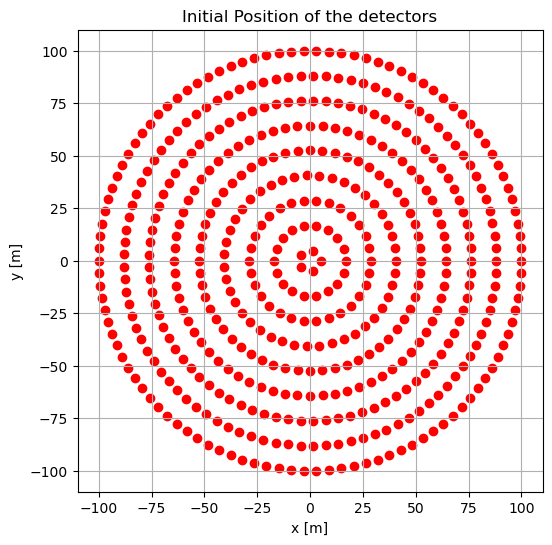

In [30]:
plt.figure(figsize = [6, 6])
plt.scatter(x.detach(), y.detach(), color = "red")
plt.grid()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Initial Position of the detectors")
plt.xlim((-110, 110))
plt.ylim((-110, 110))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2846621..16.848864].


✔ Done: generated 10 showers across 10 conditions.
Total generation time: 8.09s
Done: generated 10 bbox predictions across 10 conditions.
Total generation time: 0.01s
BBox: tensor([[-17.4371,  25.6275, -21.6853,  22.0231],
        [110.6588, 134.1575,  -5.3084,  18.1920],
        [-12.6204,  18.1962, -15.4381,  15.8667],
        [258.1268, 280.4723,  -1.3083,  21.1875],
        [ 85.5073, 109.3418,  -6.6179,  17.2841],
        [-21.1419,  25.2006, -23.4710,  23.5647],
        [-20.2975,  29.5967, -25.2024,  25.4247],
        [-15.9719,  15.2738, -15.8750,  15.8957],
        [170.9295, 228.0781, -18.8106,  39.0283],
        [-26.9478,  25.0436, -26.4943,  26.3462]])


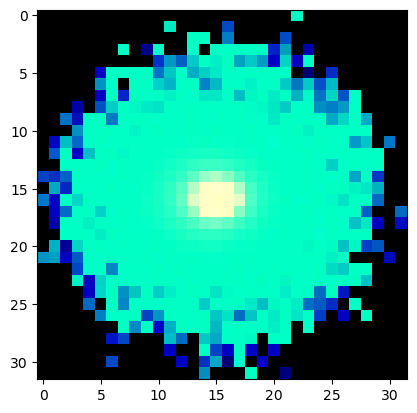

In [32]:
SWGOopt = False

N, T, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a = GenerateShowers(x, y, True, number_of_showers=10)


In [33]:
print("N:", N.shape)
print("T:", T.shape)
print("X0:", X0)
print("Y0:", Y0)
print("E:", energy.shape)
print("sin(theta):", sin_z)
print("cos(theta):", cos_z)
print("sin(phi):", sin_a)
print("cos(phi):", cos_a)

N: torch.Size([10, 500])
T: torch.Size([10, 500])
X0: tensor([  3.7123, 122.1460,   1.7224, 268.9120,  97.3255,   1.4168,   4.0674,
         -0.7138, 197.9357,  -0.9635])
Y0: tensor([-1.1855,  5.6402, -0.1243,  9.5753,  4.6428, -1.9773, -1.1400,  0.1378,
         8.7314, -1.4391])
E: torch.Size([10])
sin(theta): tensor([-0.8790,  0.6246, -0.5188,  0.9954,  0.5221, -0.8537, -0.9721, -0.5453,
         0.8880, -0.5566])
cos(theta): tensor([0.4769, 0.7809, 0.8549, 0.0954, 0.8529, 0.5208, 0.2346, 0.8382, 0.4599,
        0.8308])
sin(phi): tensor([-0.2647,  0.2257, -0.4255,  0.1149, -0.7938,  0.3658,  0.2686, -0.4268,
         0.4809, -0.9987])
cos(phi): tensor([0.9643, 0.9742, 0.9049, 0.9934, 0.6082, 0.9307, 0.9632, 0.9044, 0.8768,
        0.0519])


In [34]:
# reconstruct theta and phi from sin and cos
th = torch.atan2(sin_z, cos_z)
ph = torch.atan2(sin_a, cos_a)

Energy = 0.353 PeV
Angle = -61.5 degree


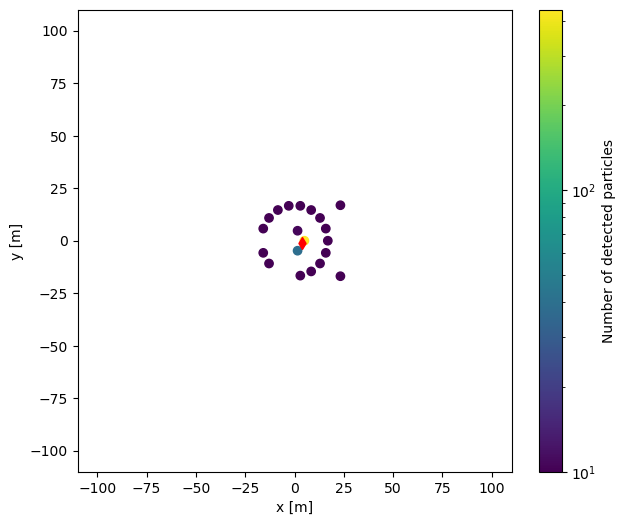

In [35]:
print(f"Energy = {energy[0].item():.3f} PeV")
print(f"Angle = {th[0].item() * 180 / np.pi:.1f} degree")

N_tmp = N[0]

idx = torch.where(N_tmp >= 1e-5)[0]
norm = LogNorm(vmin = 10, vmax = torch.max(N_tmp).item())

plt.figure(figsize = [7, 6])
scatter = plt.scatter(x[idx], y[idx], c = N_tmp[idx]*10, cmap = "viridis", norm = norm)
plt.colorbar(scatter, label='Number of detected particles')
plt.scatter(X0[0].item(), Y0[0].item(), c = "red", marker = "d")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-110, 110))
plt.ylim((-110, 110))
plt.show()

Angle = -61.5 degree
Phi = -15.4 degree


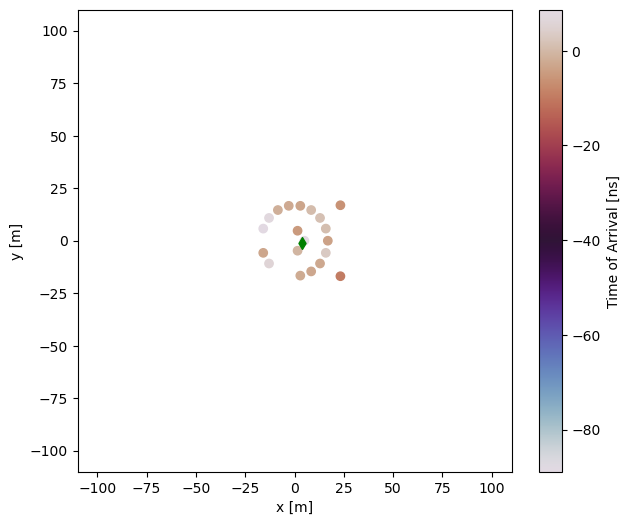

In [36]:
print(f"Angle = {th[0].item() * 180 / np.pi:.1f} degree")
print(f"Phi = {ph[0].item() * 180 / np.pi:.1f} degree")

T_tmp = T[0]

norm = Normalize(vmin = torch.min(T_tmp), vmax = torch.max(T_tmp))

idx = torch.where(N_tmp >= 1e-5)[0]
plt.figure(figsize = [7, 6])
scatter = plt.scatter(x[idx], y[idx], c = T_tmp[idx], cmap = "twilight", norm = norm)
plt.colorbar(scatter, label='Time of Arrival [ns]')
plt.scatter(X0[0].item(), Y0[0].item(), c = "green", marker = "d")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-110, 110))
plt.ylim((-110, 110))
plt.show()

## Training the Network

We first need some simulations to train our neural network. In the global variables part, you will find a variable num_events, which is set to 10000. We will use this number to generate random events.

### Train Data Generation

Number of showers in the test set = 100k

In [ ]:
# Nevents=5000

In [38]:
%%time

N, T, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a = GenerateShowers(x, y, False, number_of_showers=Nevents)

# reconstruct theta and phi from sin and cos (B)
th = torch.atan2(sin_z, cos_z)
ph = torch.atan2(sin_a, cos_a)

#Normalize the Labels:
E_norm, theta_norm, phi_norm = NormalizeLabels(energy, th, ph)
x0 = X0 / 5000 #[km]
y0 = Y0 / 5000 #[km]

# x, y are (num_det,) — broadcast to (Nevents, num_det)
x_exp = x.unsqueeze(0).expand(Nevents, -1)
y_exp = y.unsqueeze(0).expand(Nevents, -1)

# (Nevents, num_det, 4)
inputs = torch.stack([x_exp, y_exp, N, T], dim=2).float()

# (Nevents, 5)
labels = torch.stack([x0, y0, E_norm, theta_norm, phi_norm], dim=1).float()

✔ Done: generated 5000 showers across 5000 conditions.
Total generation time: 454.01s
Done: generated 5000 bbox predictions across 5000 conditions.
Total generation time: 0.01s
CPU times: user 4min 14s, sys: 3min 46s, total: 8min 1s
Wall time: 8min 1s


In [39]:
import os

os.makedirs(output_dir, exist_ok=True)

torch.save(inputs, f"{output_dir}/inputs.pt")
torch.save(labels, f"{output_dir}/labels.pt")

### Validation Set Data Generation

Number of events in the validation set = 10k, i.e 10% of the training set

In [ ]:
# Nvalidation = 1000

In [41]:
%%time

N, T, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a = GenerateShowers(x, y, False, number_of_showers=Nvalidation)

# reconstruct theta and phi from sin and cos (B)
th = torch.atan2(sin_z, cos_z)
ph = torch.atan2(sin_a, cos_a)

#Normalize the Labels:
E_norm, theta_norm, phi_norm = NormalizeLabels(energy, th, ph)
x0 = X0 / 5000 #[km]
y0 = Y0 / 5000 #[km]

# x, y are (num_det,) — broadcast to (Nvalidation, num_det)
x_exp = x.unsqueeze(0).expand(Nvalidation, -1)
y_exp = y.unsqueeze(0).expand(Nvalidation, -1)

# (Nvalidation, num_det, 4)
inputs_val = torch.stack([x_exp, y_exp, N, T], dim=2).float()

# (Nvalidation, 5)
labels_val = torch.stack([x0, y0, E_norm, theta_norm, phi_norm], dim=1).float()

✔ Done: generated 1000 showers across 1000 conditions.
Total generation time: 92.96s
Done: generated 1000 bbox predictions across 1000 conditions.
Total generation time: 0.00s
CPU times: user 54.9 s, sys: 43.3 s, total: 1min 38s
Wall time: 1min 38s


In [42]:
torch.save(inputs_val, f"{output_dir}/inputs_val.pt")
torch.save(labels_val, f"{output_dir}/labels_val.pt")

### Load the Sets

In [33]:
inputs = torch.load(f"{output_dir}/inputs.pt")
labels = torch.load(f"{output_dir}/labels.pt")

inputs_val = torch.load(f"{output_dir}/inputs_val.pt")
labels_val = torch.load(f"{output_dir}/labels_val.pt")

### Model

In [34]:
#In this part we are defining our model, which is the Neural network for our reconstruction
#We will use Mean Square Error Loss
#Optimization model is SGD, to keep consistent with our next steps

model = Reconstruction(num_detectors = Nunits)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-5)

In [35]:
dataset = TensorDataset(inputs, labels)

dataloader = DataLoader(dataset, batch_size = 256, shuffle = True, drop_last = False, num_workers = 4)

In [ ]:
%%time

val_losses = []
losses = []

early_stopper = EarlyStopping()

for num_epoch in range(1000):

    epoch_loss = 0
    total_batch = 0
    
    for batch_inputs, batch_labels in dataloader:
        batch_size = batch_inputs.size(0)

        train_x = batch_inputs.view(batch_size, -1)
        
        train_y = batch_labels.view(batch_size, -1)
        
        #Train the network
        outputs = model(train_x)

        loss = criterion(outputs, train_y)
        epoch_loss += loss.item()
        total_batch += 1

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

    #See if our loss in our validation set improves:
    val_size = inputs_val.size(0)

    val_x = inputs_val.view(val_size, -1)
    val_y = labels_val.view(val_size, -1)

    model.eval()

    with torch.no_grad():

        val_output = model(val_x)
        val_loss = criterion(val_output, val_y)
    
    val_losses.append(val_loss.item())
    # print(val_loss.item())
    early_stopper(val_loss)

    if (num_epoch + 1) % 100 == 0:
        print(f"Training is {int((num_epoch + 1) / 10)}% done, with Loss = {val_loss:.2f}")

    losses.append(epoch_loss / total_batch)


plt.plot(np.arange(1, len(losses) + 1), losses, color = "blue", label = "Training Loss")
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, color = "red", label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [ ]:
torch.save(model.state_dict(), f"{output_dir}/model_weights.pth")

In [36]:
model.load_state_dict(torch.load(f"{output_dir}/model_weights.pth"))

E_r = []
E_p = []

X_r = []
X_p = []

Y_r = []
Y_p = []

Th_r = []
Th_p = []

Ph_r = []
Ph_p = []

Ntest = 3000

N, T, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a = GenerateShowers(x, y, False, number_of_showers=Ntest)

# reconstruct theta and phi from sin and cos (B)
th = torch.atan2(sin_z, cos_z)
ph = torch.atan2(sin_a, cos_a)

#Normalize the Labels:
E_norm, theta_norm, phi_norm = NormalizeLabels(energy, th, ph)
x0 = X0 / 5000 #[km]
y0 = Y0 / 5000 #[km]


# x, y are (num_det,) — broadcast to (Ntest, num_det)
x_exp = x.unsqueeze(0).expand(Ntest, -1)
y_exp = y.unsqueeze(0).expand(Ntest, -1)

# (Ntest, num_det, 4)
inputs_test = torch.stack([x_exp, y_exp, N, T], dim=2).float()

# (Ntest, 5)
labels_test = torch.stack([x0, y0, E_norm, theta_norm, phi_norm], dim=1).float()


✔ Done: generated 1000 showers across 1000 conditions.
Total generation time: 93.30s
Done: generated 1000 bbox predictions across 1000 conditions.
Total generation time: 0.01s


In [37]:

model.eval()

with torch.no_grad():
    outputs = model(inputs_test.view(Ntest, -1))


In [38]:

x_pred = outputs[:, 0]
y_pred = outputs[:, 1]
E_pred = outputs[:, 2]


theta_pred = outputs[:, 3]
phi_pred = outputs[:, 4]
E_pred, theta_pred, phi_pred = DenormalizeLabels(E_pred, theta_pred, phi_pred)

E_p = E_pred
E_r = energy

X_r = X0
X_p = x_pred * 5000

Y_r = Y0
Y_p = y_pred * 5000

Th_r = th
Th_p = theta_pred

Ph_r = ph
Ph_p = phi_pred

/tmp/ipykernel_2422832/121563463.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E_max_plt = max(torch.abs(torch.tensor(E_r))) * 1.1
/tmp/ipykernel_2422832/121563463.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.plot(np.arange(.0, E_max_plt, .01), np.arange(.0, E_max_plt, .01), color = "black", linewidth = 4)


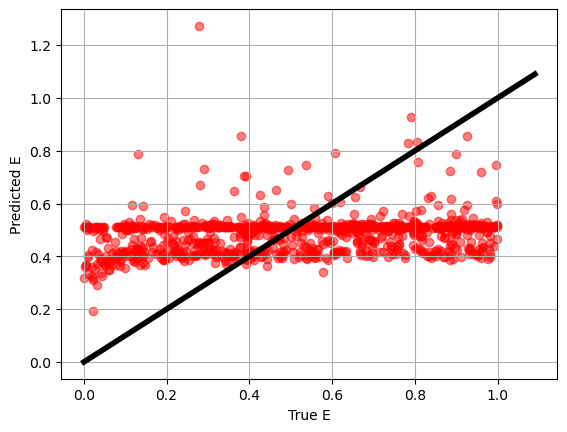

In [39]:
E_max_plt = max(torch.abs(torch.tensor(E_r))) * 1.1
plt.scatter(E_r, E_p, alpha = .5, color = "r")
plt.plot(np.arange(.0, E_max_plt, .01), np.arange(.0, E_max_plt, .01), color = "black", linewidth = 4)
plt.xlabel("True E")
plt.ylabel("Predicted E")
plt.grid()

/tmp/ipykernel_2422832/794047022.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_max_plt = (torch.abs(torch.tensor(X_r))*5000).max().item()
/tmp/ipykernel_2422832/794047022.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.scatter(torch.tensor(X_r)*5000, X_p, alpha = .5, color = "r")


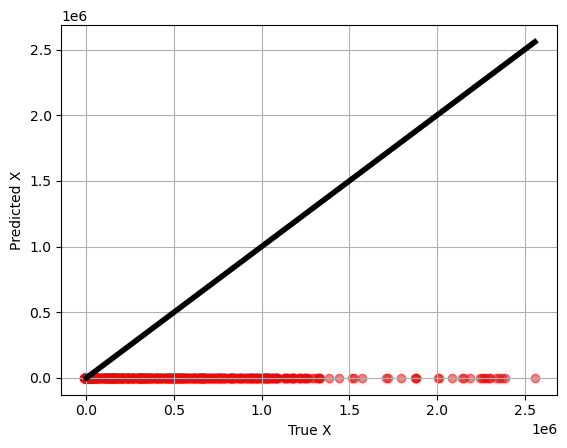

In [40]:
X_max_plt = (torch.abs(torch.tensor(X_r))*5000).max().item()
plt.scatter(torch.tensor(X_r)*5000, X_p, alpha = .5, color = "r")
plt.plot(np.arange(0, X_max_plt, 2), np.arange(0, X_max_plt, 2), color = "black", linewidth = 4)
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.grid()

/tmp/ipykernel_2422832/730230569.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_max_plt = (torch.abs(torch.tensor(Y_r))*5000).max().item()
/tmp/ipykernel_2422832/730230569.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.scatter(torch.tensor(Y_r), Y_p, alpha = .5, color = "r")


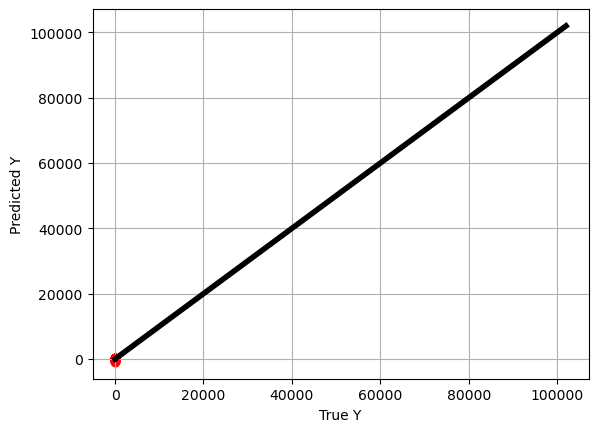

In [41]:
Y_max_plt = (torch.abs(torch.tensor(Y_r))*5000).max().item()
plt.scatter(torch.tensor(Y_r), Y_p, alpha = .5, color = "r")
plt.plot(np.arange(0, Y_max_plt, 2), np.arange(0, Y_max_plt, 2), color = "black", linewidth = 4)
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.grid()

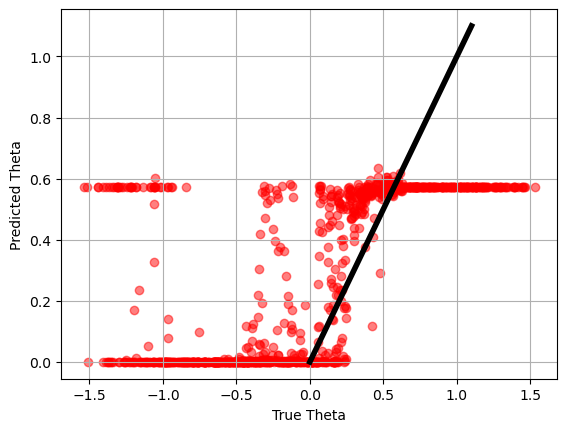

In [42]:
plt.scatter(Th_r, Th_p, alpha = .5, color = "r")
plt.plot(np.arange(0, np.pi * 65 / 180, .1), np.arange(0, np.pi * 65 / 180, .1), color = "black", linewidth = 4)
plt.xlabel("True Theta")
plt.ylabel("Predicted Theta")
plt.grid()

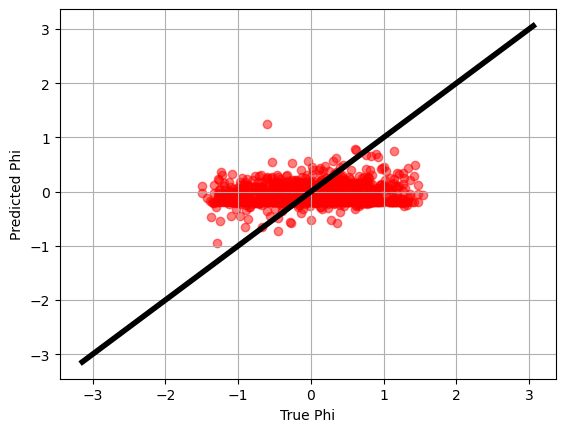

In [43]:
plt.scatter(Ph_r, Ph_p, alpha = .5, color = "r")
plt.plot(np.arange(- np.pi, np.pi, .1), np.arange(- np.pi, np.pi, .1), color = "black", linewidth = 4)
plt.xlabel("True Phi")
plt.ylabel("Predicted Phi")
plt.grid()

/tmp/ipykernel_2422832/2713287575.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data = np.abs(np.array(Y_p) - np.array(Y_r))
/tmp/ipykernel_2422832/2713287575.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx_low = np.where(np.array(E_r) <= 0.3)
/tmp/ipykernel_2422832/2713287575.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn mo

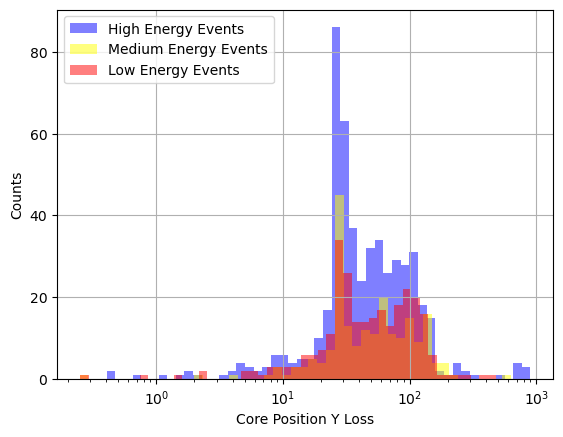

In [44]:
data = np.abs(np.array(Y_p) - np.array(Y_r))
idx_low = np.where(np.array(E_r) <= 0.3)
idx_mid = np.where((np.array(E_r) <= 0.5) & (np.array(E_r) > 0.3))
idx_high = np.where(np.array(E_r) > 0.5)

bin_high = np.logspace(np.log10(min(data[idx_high])), np.log10(max(data[idx_high])), 50)
bin_mid = np.logspace(np.log10(min(data[idx_mid])), np.log10(max(data[idx_mid])), 50)
bin_low = np.logspace(np.log10(min(data[idx_low])), np.log10(max(data[idx_low])), 50)

plt.hist(data[idx_high], bins = bin_high, alpha = .5, color = "blue", label = "High Energy Events")
plt.hist(data[idx_mid], bins = bin_mid, alpha = .5, color = "yellow", label = "Medium Energy Events")
plt.hist(data[idx_low], bins = bin_low, alpha = .5, color = "red", label = "Low Energy Events")
plt.xlabel("Core Position Y Loss")
plt.legend()
plt.xscale("log")
plt.ylabel("Counts")
plt.grid()
plt.show()

## Optimization

This is part where we start moving our arrays according to Utility Function.

You can check the utilities that we use above and see that it is > 0

So we will use -U as a "loss" function and minimize it, so that we can maximize our value

In [45]:
#First save the weights or load them so that we don't have to train the network every time we start the kernel
#Remove the commend operator "#" if you want to save

torch.save(model.state_dict(), f"{output_dir}/model_weights.pth")

model = Reconstruction(num_detectors = Nunits)

path = Path(f"{output_dir}/checkpoint.pth")
if path.exists():
    checkpoint = torch.load(f"{output_dir}/checkpoint.pth")

    model.load_state_dict(checkpoint['model_state_dict'])
    print("Updated Weights are loaded")
    
else:
    model.load_state_dict(torch.load(f"{output_dir}/model_weights.pth"))
    print("Initial Weights are loaded")

Initial Weights are loaded


In [46]:
def barycentric_coords(P, A, B, C):
    """
    Compute barycentric coordinates for each point P with respect to triangle ABC.
    P: Tensor of shape (N, 2)
    A, B, C: Tensors of shape (2,)
    """
    v0 = C - A
    v1 = B - A
    v2 = P - A

    d00 = v0 @ v0
    d01 = v0 @ v1
    d11 = v1 @ v1
    d20 = torch.sum(v2 * v0, dim=1)
    d21 = torch.sum(v2 * v1, dim=1)

    denom = d00 * d11 - d01 * d01 + 1e-8
    u = (d11 * d20 - d01 * d21) / denom
    v = (d00 * d21 - d01 * d20) / denom
    return u, v

In [47]:
def project_to_triangle(x, y):
    """
    Projects each (x[i], y[i]) point inside the triangle defined by:
    A = (-3200, 2000), B = (1800, 2000), C = (1800, -3600)
    x, y: tensors of shape (N,)
    Returns: projected x and y, tensors of shape (N,)
    """
    A = torch.tensor([-3800.0, 1500.0], device=x.device)
    B = torch.tensor([1200.0, 1500.0], device=x.device)
    C = torch.tensor([1200.0, -4100.0], device=x.device)

    P = torch.stack([x, y], dim=1)  # (N, 2)

    # Compute barycentric coordinates
    u, v = barycentric_coords(P, A, B, C)

    # Determine which points are inside the triangle
    inside = (u >= 0) & (v >= 0) & (u + v <= 1)

    # Clip to triangle: u, v ∈ [0, 1], u + v ≤ 1
    u_clipped = torch.clamp(u, 0.0, 1.0)
    v_clipped = torch.clamp(v, 0.0, 1.0)
    uv_sum = u_clipped + v_clipped
    over = uv_sum > 1.0
    u_clipped[over] = u_clipped[over] / uv_sum[over]
    v_clipped[over] = v_clipped[over] / uv_sum[over]

    v0 = C - A
    v1 = B - A
    P_proj = A + u_clipped.unsqueeze(1) * v0 + v_clipped.unsqueeze(1) * v1

    # If already inside, keep P. Otherwise, use projection.
    final_P = torch.where(inside.unsqueeze(1), P, P_proj)

    return final_P[:, 0], final_P[:, 1]  # x_proj, y_proj

In [48]:
e = 0
os.makedirs(f"{output_dir}/Python_Layout", exist_ok=True)

for i in range(1000):

    p_layout = Path(f"{output_dir}/Python_Layout/Layout_{i + 1}.txt")
    
    if p_layout.exists():
        data = np.loadtxt(p_layout)
        
        x = torch.tensor(data[:, 0], dtype = torch.float32)
        y = torch.tensor(data[:, 1], dtype = torch.float32)
        e = i + 1

if e > 0:
    print(f"Updated Layout {e} is initialized")

else:
    print("First Layout is initialized")

class LearnableXY(torch.nn.Module):
    """Small module holding detector x,y positions as learnable parameters.

    The parameters can be optimized with standard PyTorch optimizers to change the layout.
    """
    def __init__(self, x_init, y_init):
        super().__init__()
        self.x = torch.nn.Parameter(x_init)
        self.y = torch.nn.Parameter(y_init)

    def forward(self):
        """Return current learnable coordinates as (x, y)."""
        return self.x, self.y

xy_module = LearnableXY(x, y)

First Layout is initialized


In [49]:
def push_apart(module, min_dist = 2 * TankRadius):
    """Enforce a minimum separation between detectors by small pairwise displacements.

    Parameters:
        module (LearnableXY): module exposing `x` and `y` parameters via forward().
        min_dist (float): desired minimum separation between detectors.
    """
    x, y = module()  # Correctly calls forward()
    coords = torch.stack([x, y], dim=1)  # shape (N, 2)

    with torch.no_grad():
        for i in range(coords.shape[0]):
            diffs = coords[i] - coords
            dists = torch.norm(diffs, dim=1)
            mask = (dists < min_dist) & (dists > 0)

            for j in torch.where(mask)[0]:
                direction = diffs[j] / dists[j]
                displacement = 0.5 * (min_dist - dists[j]) * direction
                coords[i] += displacement
                coords[j] -= displacement

        # Update learnable parameters in-place
        module.x.data.copy_(coords[:, 0])
        module.y.data.copy_(coords[:, 1])

In [52]:
%%time

#Now we do the optimization step
SWGOopt = True
optimizer = torch.optim.SGD(xy_module.parameters(), lr = 5, momentum = .9)

if path.exists():
    checkpoint = torch.load(path)  # or map_location=... if needed
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    num_epoch = checkpoint.get("epoch") + 1
    loss = checkpoint.get("loss")
    
    print(f"Optimizer is initialized from the last epoch {num_epoch}")

else:
    num_epoch = 0
    print("Optimizer is initialized")

max_grad = 10.

Nbatch = 500

if num_epoch < 20:
    Nfinetune = 2500

elif num_epoch >= 20:
    Nfinetune = 5000

U_vals = []
U_pr_vals = []
U_e_vals = []
U_th_vals = []

for epoch in range(num_epoch, num_epoch + 100):
    x1, y1 = xy_module()
    
    N_list, T_list, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a = GenerateShowers(x1, y1, False, number_of_showers=Nbatch)
    
    # reconstruct theta and phi from sin and cos
    th = torch.atan2(sin_z, cos_z)
    ph = torch.atan2(sin_a, cos_a)

    #Normalize the Labels:
    E_norm, theta_norm, phi_norm = NormalizeLabels(energy, th, ph)
    x0 = X0 / 5000 #[km]
    y0 = Y0 / 5000 #[km]

    x = x1.unsqueeze(0).repeat(Nbatch, 1)
    y = y1.unsqueeze(0).repeat(Nbatch, 1)
    
    # (Nbatch, 5)
    labels_batch = torch.stack([x0, y0, E_norm, theta_norm, phi_norm], dim=1).float()
    
    #(Nbatch, num_detectors, 4)
    events_batch = torch.stack((x, y, N_list, T_list), dim = 2) 
    
    model.eval()

    preds_batch = model(events_batch.view(Nbatch, -1))

    #Denormalize the predictions
    preds_x = preds_batch[:, 0] * 5000
    preds_y = preds_batch[:, 1] * 5000
    preds_e, preds_th, preds_phi = DenormalizeLabels(preds_batch[:, 2], preds_batch[:, 3], 
                                                                                preds_batch[:, 4])

    #Compute the reconstructability score for each event:
    r_score = reconstructability(events_batch[:, :, 2])
    density = Nbatch / ((labels_batch[:, 0].max() - labels_batch[:, 0].min()) * 
                        (labels_batch[:, 1].max() - labels_batch[:, 1].min()))

    #Compute Utility:
    U = 1e-2 * U_TH(preds_th, labels_batch[:, 3], r_score) + U_E(preds_e, labels_batch[:, 2], r_score) + U_PR(r_score) / torch.sqrt(density)

    #Save the utility values to plot
    U_vals.append(U.item())
    U_pr_vals.append((U_PR(r_score) / torch.sqrt(density)).item())
    U_e_vals.append(U_E(preds_e, labels_batch[:, 2], r_score).item())
    U_th_vals.append(1e-2 * U_TH(preds_th, labels_batch[:, 3], r_score).item())

    #sym_loss = symmetry_loss(x1, y1, n_symmetry = 3)
    print(f"Utility: {U:.2f}")

    #Use utility as - Loss, we have a penalty term to make configuration symmetric
    Loss = - U #+ lambda_sym * sym_loss

    Loss.backward()

    torch.nn.utils.clip_grad_norm_(xy_module.parameters(), max_norm = max_grad)

    optimizer.step()

    with torch.no_grad():
        push_apart(xy_module)

    #This part is done to keep the detectors inside the site
    """
    with torch.no_grad():
        x_proj, y_proj = project_to_triangle(x1.view(-1), y1.view(-1))
        x1.copy_(x_proj)
        y1.copy_(y_proj)
    """
    
    optimizer.zero_grad()

    #Now we need to generate new events that with the new layout so that we can fine tune our NN when it's necessary
    if (epoch + 1) % 5 == 0:
        print(f"Fine Tune at epoch {epoch + 1}")
        
        with torch.no_grad():
            x2, y2 = xy_module()
            x = x2.detach()
            y = y2.detach()

            #Generate events to fine tune the network
            N, T, X0, Y0, energy, sin_z, cos_z, sin_a, cos_a = GenerateShowers(x, y, False, number_of_showers=Nfinetune)
            
            # reconstruct theta and phi from sin and cos
            theta = torch.atan2(sin_z, cos_z)
            phi = torch.atan2(sin_a, cos_a)

            energy, theta, phi = NormalizeLabels(energy, theta, phi)
            X0 /= 5000
            Y0 /= 5000

            finetune_trues = torch.stack([X0, Y0, energy, theta, phi], dim = 1)
            
            x_exp = x.unsqueeze(0).expand(Nfinetune, -1)
            y_exp = y.unsqueeze(0).expand(Nfinetune, -1)
            finetune_events = torch.stack((x_exp, y_exp, N, T), dim = 2) 

        ReconstructionNN = model
        ReconstructionNN.train()
        criterion = nn.MSELoss()
        optimizerNN = torch.optim.Adam(ReconstructionNN.parameters(), lr = 5e-5)

        dataset = TensorDataset(finetune_events, finetune_trues)
        dataloader = DataLoader(dataset, batch_size = 32, shuffle = True, drop_last = True, num_workers = 4)

        for j in range(5):
            for ft_batch, ft_trues in dataloader:
                batch_size = ft_batch.size(0)

                train_x = ft_batch.view(batch_size, -1)
        
                train_y = ft_trues.view(batch_size, 5)
        
                #Train the network
                outputs = ReconstructionNN(train_x)

                lossT = criterion(outputs, train_y)

                lossT.backward()
                optimizerNN.step()

                optimizerNN.zero_grad()

    #I will save the layouts and weights here so that I can stop whenever and continue later
    torch.save({"epoch": epoch, "loss": Loss, "model_state_dict": model.state_dict(), 
                "optimizer_state_dict": optimizer.state_dict()}, f"{output_dir}/checkpoint.pth")
    
    np.savetxt(f"{output_dir}/Python_Layout/Layout_{epoch + 1}.txt", np.column_stack((x1.detach().numpy(), y1.detach().numpy())))

Optimizer is initialized from the last epoch 4
✔ Done: generated 100 showers across 100 conditions.
Total generation time: 11.75s
Done: generated 100 bbox predictions across 100 conditions.
Total generation time: 0.00s
Utility: 0.97
Fine Tune at epoch 5
✔ Done: generated 25 showers across 25 conditions.
Total generation time: 6.33s
Done: generated 25 bbox predictions across 25 conditions.
Total generation time: 0.00s
✔ Done: generated 100 showers across 100 conditions.
Total generation time: 11.76s
Done: generated 100 bbox predictions across 100 conditions.
Total generation time: 0.00s
Utility: 0.94
CPU times: user 26.3 s, sys: 5.22 s, total: 31.5 s
Wall time: 38.3 s


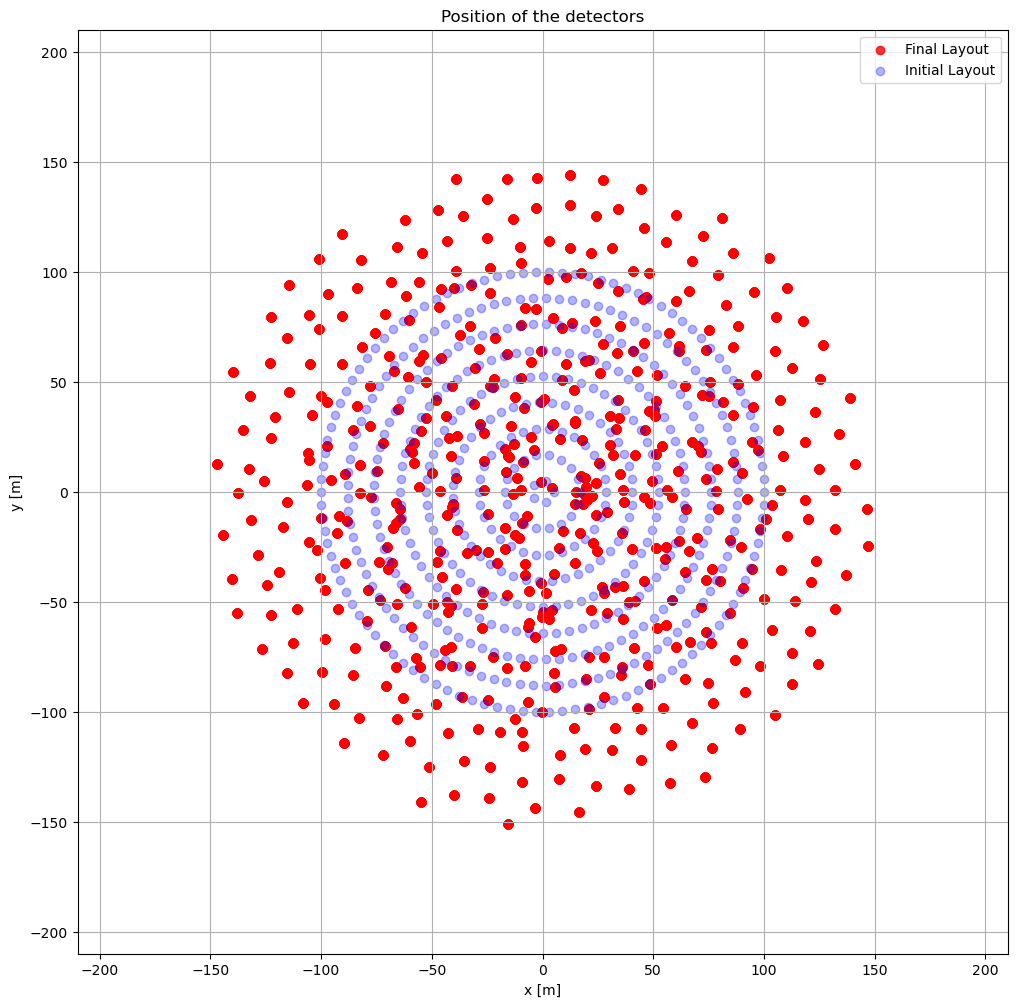

In [53]:
a, b = Layouts(n_detectors=Nunits, n_rings=9)

plt.figure(figsize = [12, 12])
plt.scatter(x.detach(), y.detach(), color = "red", alpha = .8, label = "Final Layout")
plt.scatter(a, b, color = "blue", alpha = .3, label = "Initial Layout")
#plt.plot([-3800, 1200, 1200, -3800], [1500, 1500, -4100, 1500], "k--", label = "SWGO Site")

#Add Shower Simulation Area
#ax = plt.gca()
#rect = patches.Rectangle((-3000, -3000), 6000, 6000, linewidth=1.5, edgecolor='green', facecolor='green',
                         #alpha=0.1, label='Shower Simulation Area')
#ax.add_patch(rect)

plt.grid()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Position of the detectors")
plt.legend()
plt.xlim((-210, 210))
plt.ylim((-210, 210))
plt.show()

In [54]:
utility_path = Path(f"{output_dir}/Python_Layout/Utilities.txt")

if utility_path.exists():
    data = np.loadtxt(utility_path)
    u_t = data
    #u_p = data[:, 1]
    #u_e = data[:, 2]
    #u_a = data[:, 3]

    u_t = np.append(u_t, np.array(U_vals).ravel())
    #u_p = np.append(u_p, np.array(U_pr_vals).ravel())
    #u_e = np.append(u_e, np.array(U_e_vals).ravel())
    #u_a = np.append(u_a, np.array(U_th_vals).ravel())

    #data = np.column_stack((u_t, u_p, u_e, u_a))

    np.savetxt(utility_path, u_t)
    
else:
    u_t = U_vals
    #u_p = U_pr_vals
    #u_e = U_e_vals
    #u_a = U_th_vals
    
    #data = np.column_stack((u_t, u_p, u_e, u_a))
    np.savetxt(utility_path, u_t)

In [55]:
mean_ut = [np.mean(u_t[i - 4: i]) for i in range(4, len(u_t))]

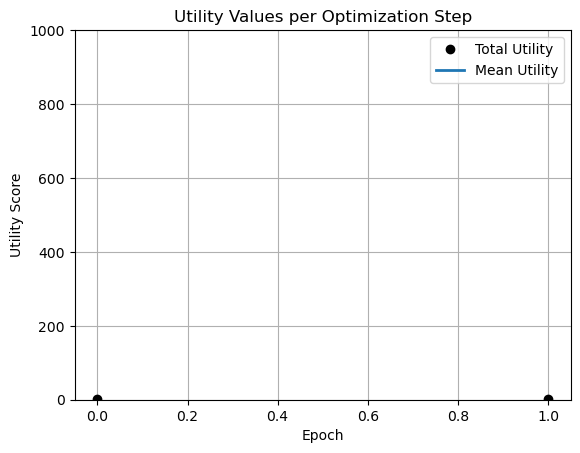

In [56]:
plt.plot(u_t, color = "black", linestyle = "none", marker = "o", linewidth = .5, label = "Total Utility")
plt.plot(np.arange(4, len(u_t)), mean_ut, linestyle = "-", linewidth = 2, label = "Mean Utility")
#plt.plot(u_p, color = "orange", linestyle = "-.", label = "Reconstructability Utility")
#plt.plot(u_e, color = "green", linestyle = "-.", label = "Energy Utility")
#plt.plot(u_a, color = "purple", linestyle = "-.", label = "Angle Utility")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Utility Score")
plt.ylim((0, np.max(u_t) + 1000))
plt.title("Utility Values per Optimization Step")
plt.show()